In [1]:

%cd xcfl

[Errno 2] No such file or directory: 'xcfl'
/Users/mohammad/xcfl/xcfl


In [1]:
%matplotlib inline
from IPython.display import clear_output
import os
from copy import deepcopy

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models import ConvNet
from helper import ExperimentLogger, display_train_stats
from fl_devices import Server, Client
from data_utils import split_noniid, CustomSubset
from saliency.integrated_gradients import IntegratedGradients
from saliency.utils import load_image, make_grayscale, make_black_white, show_mask
import colorcet as cc
import random
from numpy import unravel_index
import torch.nn.functional as nnf
from statistics import mean 

datasets.MNIST.resources = [
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
        ]

torch.manual_seed(42)
np.random.seed(42)

import numpy as np
import torch
from torchvision import models
import cv2
import torch.nn.functional as F
from utils import calculate_outputs_and_gradients, generate_entrie_images
from integrated_gradients import random_baseline_integrated_gradients
from visualization import visualize
import argparse
import os
from PIL import Image
import time



In [2]:
def saliency_ig(model, image):
    integrated_gradients = IntegratedGradients(model)
    # image = load_image(image)
    # rgb_mask = integrated_gradients.get_mask(image_tensor=image)

    # Individual gradients can be processed before being integrated
    # by passing a function to the 'process' parameter of the
    # 'get_mask' method. By passing e.g. 'np.abs' the visual result
    # can be improved.
    abs_rgb_mask = integrated_gradients.get_mask(image_tensor=image, process=np.abs)
    # integrated_gradients.
    # print(abs_rgb_mask)
    # print("done")

    # gray_mask = make_grayscale(rgb_mask)
    # bw_mask = make_black_white(rgb_mask)
    bw_mask_alt = make_black_white(abs_rgb_mask)

    a=bw_mask_alt
    # print(unravel_index(a.argmax(), a.shape))

    # figure, axes = plt.subplots(1, 3, figsize=(12, 12), tight_layout=True)
    # show_mask(gray_mask.T, title='Integrated Gradients', cmap=cc.cm.gray, axis=axes[0])
    # show_mask(bw_mask.T, title='Black/White', cmap=cc.cm.gray, axis=axes[1])
    # show_mask(bw_mask_alt.T, title='Processed', cmap=cc.cm.gray, axis=axes[2])
    return unravel_index(a.argmax(), a.shape)

In [3]:
def listsMean(ls):
    return np.mean( np.array(ls), axis=0 )


In [4]:
nclist = [1, 2, 4, 8]

In [13]:
def calculate(N_CLIENTS):

    print("Clients: ", end="")
    print(N_CLIENTS)

    DIRICHLET_ALPHA = 1.0

    data = datasets.EMNIST(root=".", split="byclass", download=True)

    mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
        'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
        'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
        'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1')

    idcs = np.random.permutation(len(data))
    train_idcs, test_idcs = idcs[:10000], idcs[10000:20000]
    train_labels = data.train_labels.numpy()

    client_idcs = split_noniid(train_idcs, train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)

    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, test_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        if i < N_CLIENTS / 2:
            client_datum.subset_transform = transforms.Compose([transforms.RandomRotation((180,180)),
                                                        transforms.ToTensor()])
        else:
            client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    clients = [Client(ConvNet, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, idnum=i)
           for i, dat in enumerate(client_data)]
    server = Server(ConvNet, test_data)


    COMMUNICATION_ROUNDS = 80
    EPS_1 = 0.4
    EPS_2 = 1.6

    # Training
    start = time.time()

    cfl_stats = ExperimentLogger()

    cluster_indices = [np.arange(len(clients)).astype("int")]
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]


    for c_round in range(1, COMMUNICATION_ROUNDS+1):

        if c_round == 1:
            for client in clients:
                client.synchronize_with_server(server)

        participating_clients = server.select_clients(clients, frac=1.0)

        for client in participating_clients:
            train_stats = client.compute_weight_update(epochs=1)
            client.reset()

        similarities = server.compute_pairwise_similarities(clients)

        cluster_indices_new = []
        for idc in cluster_indices:
            max_norm = server.compute_max_update_norm([clients[i] for i in idc])
            mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])

            if mean_norm<EPS_1 and max_norm>EPS_2 and len(idc)>2 and c_round>20:

                server.cache_model(idc, clients[idc[0]].W, acc_clients)

                c1, c2 = server.cluster_clients(similarities[idc][:,idc])
                cluster_indices_new += [c1, c2]

                cfl_stats.log({"split" : c_round})

            else:
                cluster_indices_new += [idc]


        cluster_indices = cluster_indices_new
        client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

        server.aggregate_clusterwise(client_clusters)

        acc_clients = [client.evaluate() for client in clients]

        cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                    "rounds" : c_round, "clusters" : cluster_indices})


    display_train_stats(cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS)

    end = time.time()
    print("Training Duration: ", end="")
    print(end - start)

    for idc in cluster_indices:
        server.cache_model(idc, clients[idc[0]].W, acc_clients)

    print("accuracies: ", end="")
    print(cfl_stats.acc_clients[-1])

    # participating_clients = server.select_clients(clients, frac=1.0)
    # print(type(clients[0].data[0][0]))
    drop = []
    for client in clients:
        dataiter = iter(client.eval_loader)
        x, y = next(dataiter)
        classes = client.data.dataset.classes
        sample = 5
        dropc = []
        # print(classes[client.data.dataset.targets[sample]])

        for i in range(10):
            mdl = client.model
            mdl.load_state_dict(client.W)
            mdl.eval()
            dropj = []
            for j in range(50):
                coor = saliency_ig(client.model, x[i,0][None, ...][None, ...])
                x[i,0][coor[0]][coor[1]] = 0
                output = mdl(x[i,0][None, ...][None, ...])
                prob = nnf.softmax(output, dim=1)
                # print(prob[0])
                # print(output)
                # print(output[0][y[i].item()])
                # prob.item(y[i].item())
                dropj.append(prob[0][y[i].item()].item())
                # plt.show()
            dropc.append(dropj)
            # print(mean(dropj))
        # print(dropc)
        drop.append(listsMean(dropc))
        client.reset()

    result = listsMean(drop)
    plt.plot(result)
    print(sum(result))
    print()

Clients: 1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


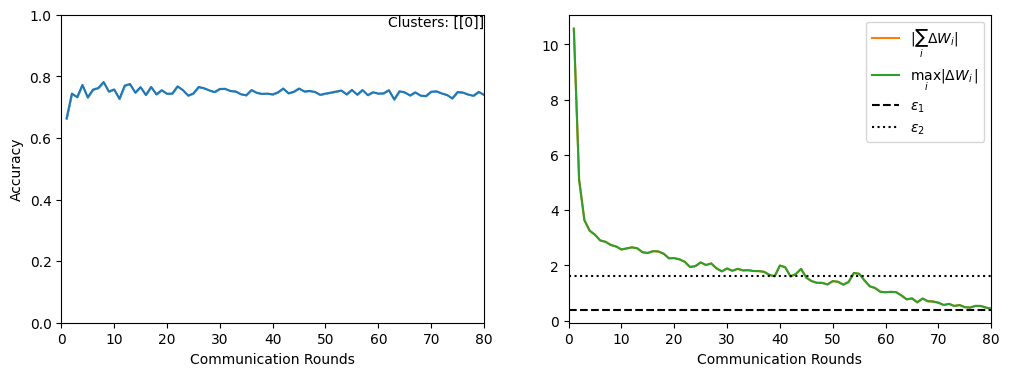

Training Duration: 111.90176320075989
accuracies: [0.74]
19.261504543799905

Clients: 2


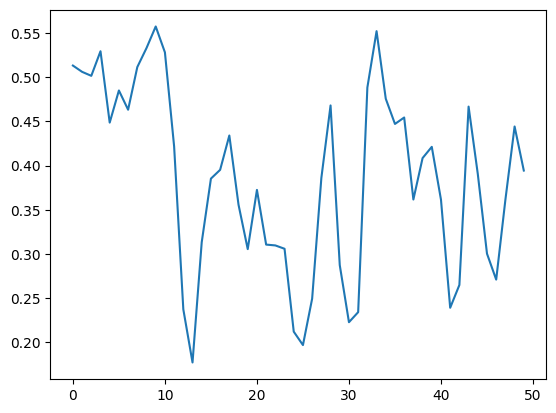

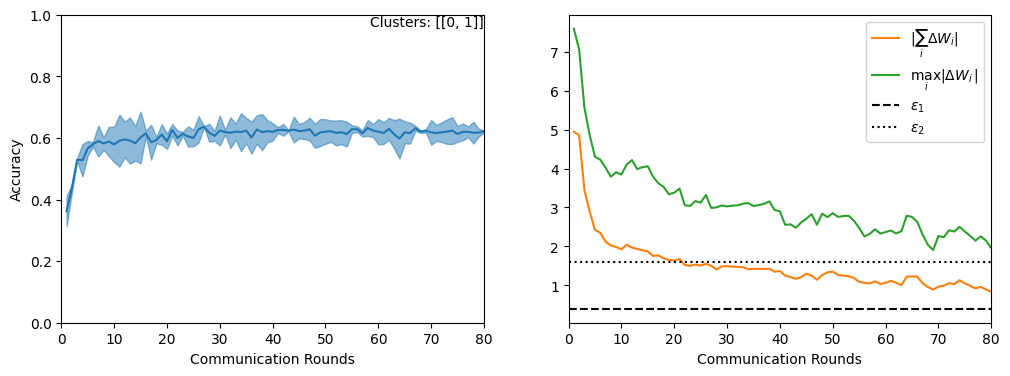

Training Duration: 109.849613904953
accuracies: [0.6178960096735188, 0.6248934356351236]
20.77477865203544

Clients: 4


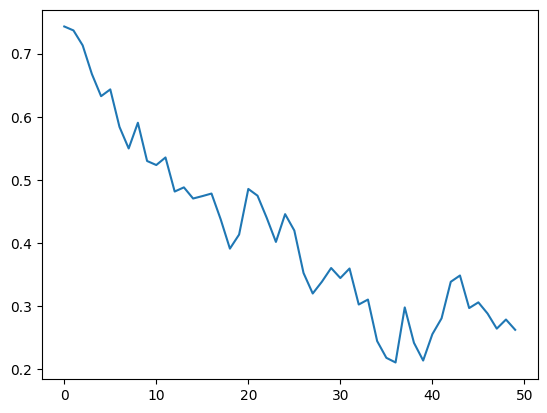

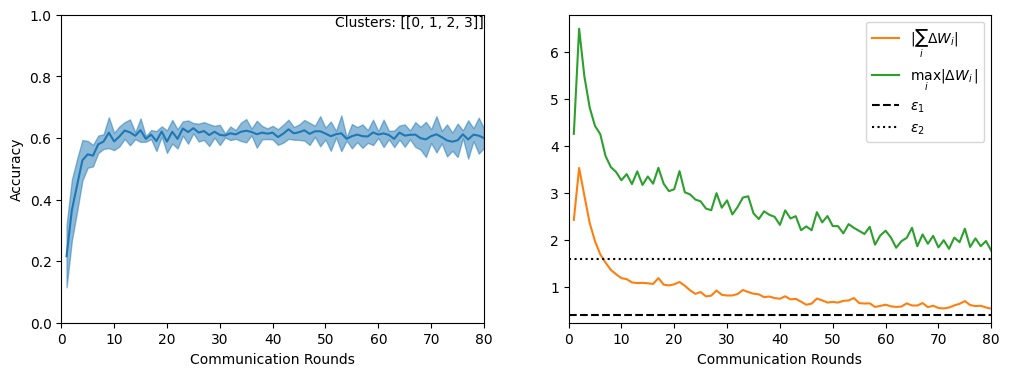

Training Duration: 108.85279512405396
accuracies: [0.5482625482625483, 0.5979381443298969, 0.6226053639846744, 0.6289473684210526]
15.406116846226602

Clients: 8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


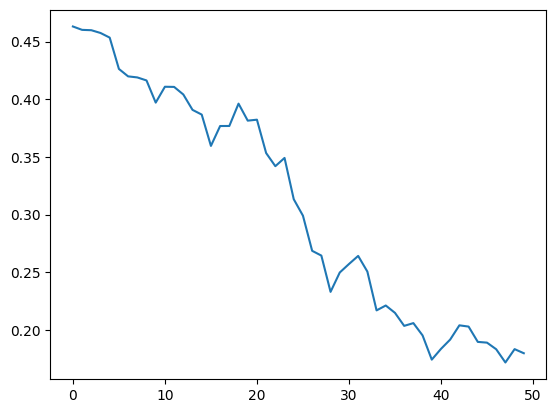

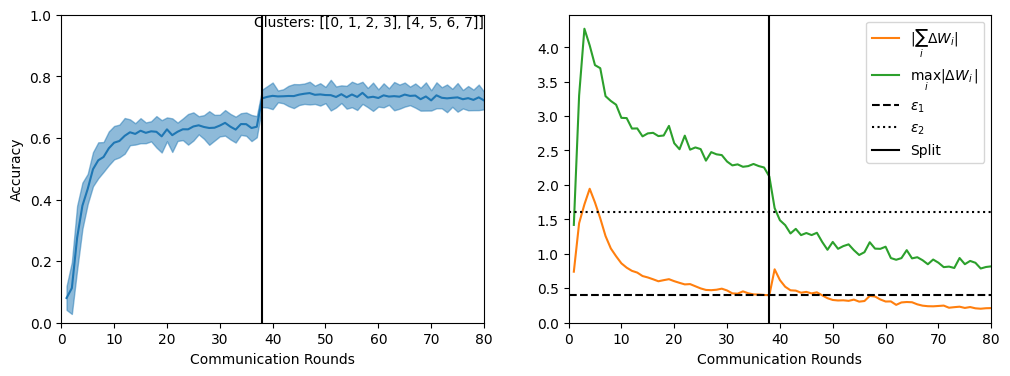

Training Duration: 109.56103181838989
accuracies: [0.7421875, 0.6930232558139535, 0.7402597402597403, 0.710204081632653, 0.7564575645756457, 0.6804979253112033, 0.7572815533980582, 0.6936170212765957]
17.947756844779633



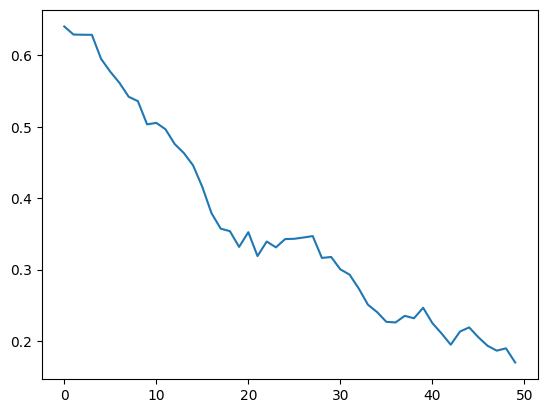

In [14]:
for N_CLIENTS in nclist:
    calculate(N_CLIENTS)
    

We will run experiments with the EMNIST data set of handwritten characters. We simulate a scenario with 10 clients and distribute the data among the clients in a non-iid way accoding to a dirichlet distribution parametrized with alpha=1.0 . The distribution of data is shown below.

Next, we simulate a clustering structure in the client population, by rotating the data for half of the first 5 clients by 180 degree. We display 10 data samples from the 1st and the 6th client for illustration.

Now everything is set up to run our Clustered Federated Learning algorithm. During training, we will track the mean and std client accuracies, as well as the average and maximum client update norms.

The training process resulted in multiple models for every client: A Federated Learning base model as well as more specialized models for the different clusters.  We can now compare their accuracies on the clients' validation sets, and assign each client the model which performed best.

In [26]:
results = np.zeros([10, len(server.model_cache)])
for i, (idcs, W, accs) in enumerate(server.model_cache):
    results[idcs, i] = np.array(accs)

In [27]:
frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i)
                                                    for i in range(results.shape[1]-1)],
            index = ["Client {}".format(i) for i in range(results.shape[0])])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: orange' if v else '' for v in is_max]
frame.T.style.apply(highlight_max)

,Client 0,Client 1,Client 2,Client 3,Client 4,Client 5,Client 6,Client 7,Client 8,Client 9
FL Model,0.631068,0.651685,0.679167,0.632911,0.488722,0.605882,0.520231,0.627119,0.542453,0.579787
Model 0,0.728155,0.812734,0.804167,0.763713,0.684211,0.000000,0.000000,0.000000,0.000000,0.000000
Model 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.741176,0.658960,0.694915,0.745283,0.771277


As we can see, clustering improoved the accuracy for all clients by about 10%.